In [1]:
import os
import requests
import json
import warnings
from warnings import filterwarnings
filterwarnings(action="ignore")
from pprint import pprint
import pandas as pd
import statsmodels.tsa.stattools as sts
from scipy.stats.distributions import chi2
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResultsWrapper
import statsmodels.graphics.tsaplots as sgt
from dotenv import load_dotenv
import matplotlib.pyplot as plt
api_key = os.getenv("API_KEY")
api_base_url = os.getenv("API_BASE_URL")
api_url = f"{api_base_url}={api_key}"

load_dotenv()

True

In [2]:
def LLR_test(mod_1, mod_2, df=1):
    L1 = mod_1.fit().llf
    L2= mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, df).round(3)
    return p

### Extract Sample data

In [3]:
filename = "MTN.json"
with open(filename) as f:
    data = json.load(f)

data

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'MTNOY',
  '3. Last Refreshed': '2024-08-27',
  '4. Output Size': 'Compact',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2024-08-27': {'1. open': '5.3100',
   '2. high': '5.4400',
   '3. low': '5.3100',
   '4. close': '5.4100',
   '5. volume': '5222'},
  '2024-08-26': {'1. open': '5.4900',
   '2. high': '5.4900',
   '3. low': '5.4113',
   '4. close': '5.4400',
   '5. volume': '9342'},
  '2024-08-23': {'1. open': '5.2700',
   '2. high': '5.4400',
   '3. low': '5.2400',
   '4. close': '5.4000',
   '5. volume': '9404'},
  '2024-08-22': {'1. open': '5.0910',
   '2. high': '5.1000',
   '3. low': '4.9800',
   '4. close': '5.0220',
   '5. volume': '9686'},
  '2024-08-21': {'1. open': '5.0350',
   '2. high': '5.0800',
   '3. low': '5.0050',
   '4. close': '5.0100',
   '5. volume': '3612'},
  '2024-08-20': {'1. open': '5.1000',
   '2. high': '5.1000',
   '3. low': '4.9900',
   '4.

### Data Pre-processing

In [4]:
# Identifying relevant keys and values for extraction
data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [5]:
data["Time Series (Daily)"]

{'2024-08-27': {'1. open': '5.3100',
  '2. high': '5.4400',
  '3. low': '5.3100',
  '4. close': '5.4100',
  '5. volume': '5222'},
 '2024-08-26': {'1. open': '5.4900',
  '2. high': '5.4900',
  '3. low': '5.4113',
  '4. close': '5.4400',
  '5. volume': '9342'},
 '2024-08-23': {'1. open': '5.2700',
  '2. high': '5.4400',
  '3. low': '5.2400',
  '4. close': '5.4000',
  '5. volume': '9404'},
 '2024-08-22': {'1. open': '5.0910',
  '2. high': '5.1000',
  '3. low': '4.9800',
  '4. close': '5.0220',
  '5. volume': '9686'},
 '2024-08-21': {'1. open': '5.0350',
  '2. high': '5.0800',
  '3. low': '5.0050',
  '4. close': '5.0100',
  '5. volume': '3612'},
 '2024-08-20': {'1. open': '5.1000',
  '2. high': '5.1000',
  '3. low': '4.9900',
  '4. close': '5.0600',
  '5. volume': '16192'},
 '2024-08-19': {'1. open': '4.9900',
  '2. high': '5.1000',
  '3. low': '4.9900',
  '4. close': '5.0800',
  '5. volume': '14701'},
 '2024-08-16': {'1. open': '4.8600',
  '2. high': '5.0000',
  '3. low': '4.8600',
  '4. 

In [6]:
# Conversion of data to a DataFrame and transposition to allow for easier manipulation
df_comp = pd.DataFrame(data["Time Series (Daily)"]).T

In [7]:
df_comp.describe()

,1. open,2. high,3. low,4. close,5. volume
count,100,100,100,100,100
unique,78,79,75,82,99
top,4.6600,5.1000,4.5100,4.4800,14662
freq,4,3,4,3,2


###### As suggested by the name, time series deal with dates and numeric types and the data currently possesses 'Object' types

In [8]:
# Idenfication of types within dataset
df_comp.dtypes

1. open      object
2. high      object
3. low       object
4. close     object
5. volume    object
dtype: object

In [9]:
df_comp.head()

,1. open,2. high,3. low,4. close,5. volume
2024-08-27,5.3100,5.4400,5.3100,5.4100,5222
2024-08-26,5.4900,5.4900,5.4113,5.4400,9342
2024-08-23,5.2700,5.4400,5.2400,5.4000,9404
2024-08-22,5.0910,5.1000,4.9800,5.0220,9686
2024-08-21,5.0350,5.0800,5.0050,5.0100,3612


In [10]:
# Conversion of 'Object' types to float
for i in df_comp.columns:
    df_comp[i] = df_comp[i].astype(float)

In [11]:
df_comp.dtypes

1. open      float64
2. high      float64
3. low       float64
4. close     float64
5. volume    float64
dtype: object

##### Interestingly, the series or the data, from source, gives it's data in reverse chronological order and to allow for proper splits,
##### must be reversed

In [12]:
df_comp = df_comp[::-1]

In [13]:
df = df_comp.copy()

In [14]:
del df["1. open"],df["2. high"],df["3. low"],df["5. volume"],

In [15]:
df.rename(columns= {"4. close":"mkt_price"}, inplace=True)

In [16]:
df["dates"] = df.index

In [17]:
df.dates = pd.to_datetime(df.dates, yearfirst=True)
df.set_index("dates", inplace=True)
df = df.asfreq('b')

In [18]:
df.fillna(method="ffill", inplace=True)

In [19]:
size = int(0.8 * len(df))
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [20]:
df_train.describe()

,mkt_price
count,82.000000
mean,4.608901
std,0.273882
min,4.102000
25%,4.430500
50%,4.577000
75%,4.770000
max,5.290000


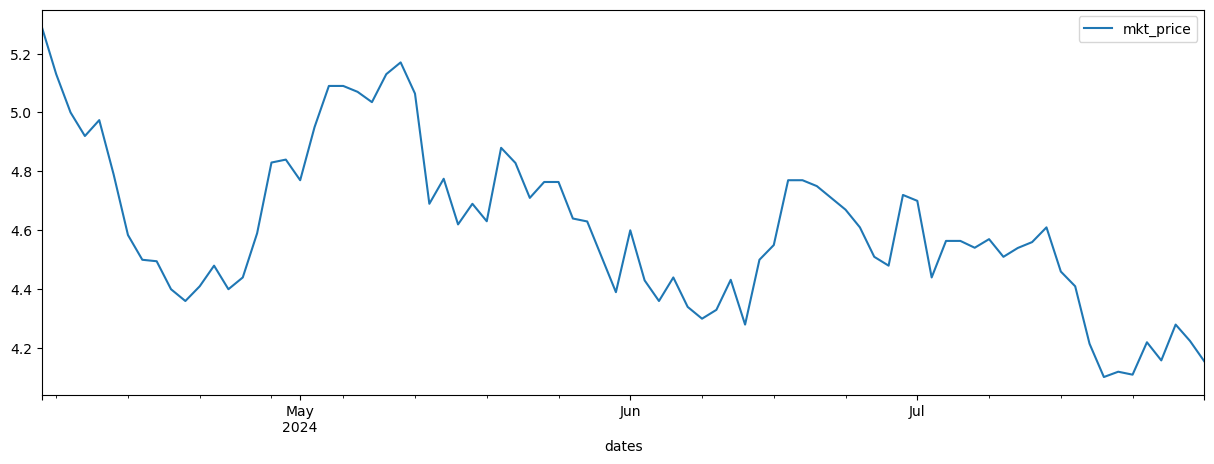

In [21]:
df_train.plot(figsize=(15,5));

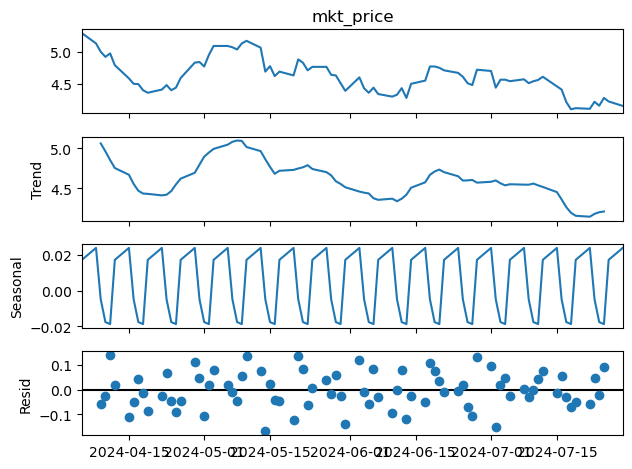

In [53]:
s_dec_additive = seasonal_decompose(df_train.mkt_price, model="additive")
s_dec_additive.plot();

In [23]:
sts.adfuller(df_train.mkt_price)

(-2.4889077544769256,
 0.11819656757514962,
 0,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 -95.95501960277258)

###### From the second line of the above output, the series in question is non-stationary. 

##### Computation of returns on prices

In [24]:
df_train["returns"] = df_train.mkt_price.pct_change().mul(100)

In [25]:
sts.adfuller(df_train.returns[1:])

(-9.195930798418186,
 2.0628092351707582e-15,
 0,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 326.5430646350761)

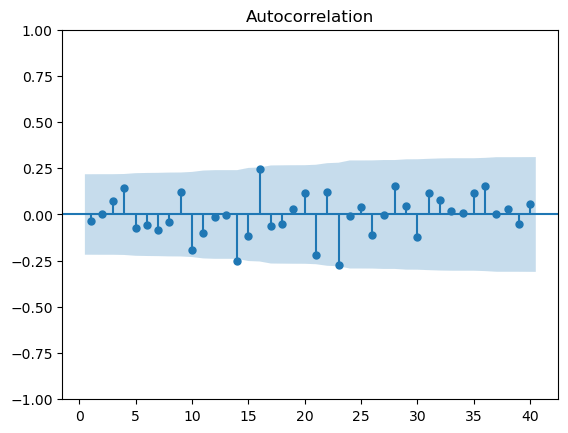

In [26]:
sgt.plot_acf(df_train.returns[1:], lags=40, zero=False);

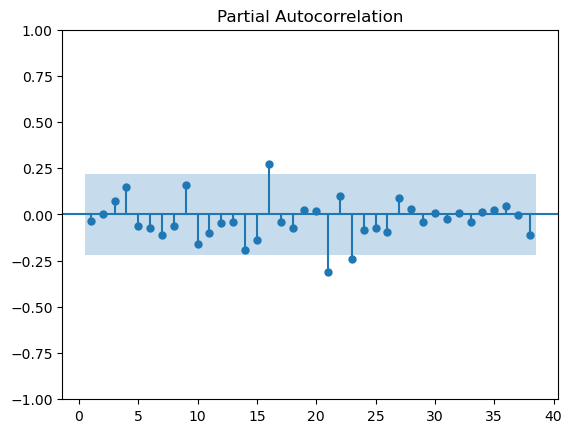

In [27]:
sgt.plot_pacf(df_train.returns[1:], lags=38, zero=False);

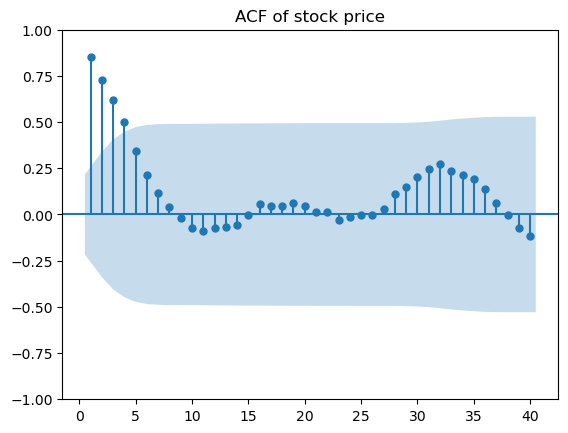

In [28]:
sgt.plot_acf(df_train.mkt_price, lags=40, zero=False)
plt.title("ACF of stock price");

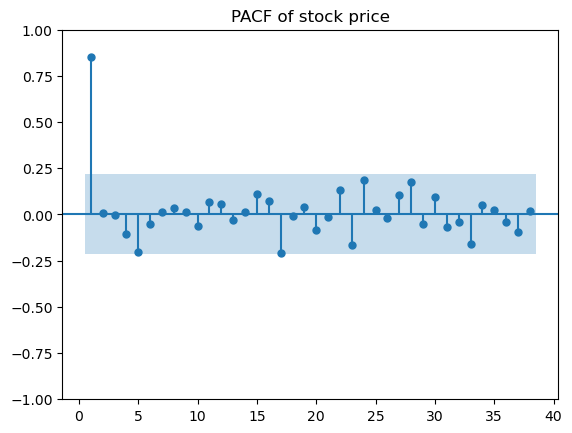

In [29]:
sgt.plot_pacf(df_train.mkt_price, lags=38, zero=False)
plt.title("PACF of stock price");

In [30]:
mod_ma =  ARIMA(df_train.mkt_price, order=(0, 0, 1))
results_ma = mod_ma.fit()
print(results_ma.summary())

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  22.343
Date:                Sat, 07 Sep 2024   AIC                            -38.687
Time:                        15:44:55   BIC                            -31.467
Sample:                    04-05-2024   HQIC                           -35.788
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6110      0.037    125.564      0.000       4.539       4.683
ma.L1          0.7360      0.089      8.236      0.000       0.561       0.911
sigma2         0.0336      0.006      5.249      0.0

In [31]:
mod_ma2 =  ARIMA(df_train.mkt_price, order=(0, 0, 2))
results_ma2 = mod_ma2.fit()
print(results_ma2.summary())
print(f"LLR_Test: {LLR_test(mod_ma, mod_ma2)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  39.393
Date:                Sat, 07 Sep 2024   AIC                            -70.785
Time:                        15:44:55   BIC                            -61.159
Sample:                    04-05-2024   HQIC                           -66.920
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6106      0.043    107.318      0.000       4.526       4.695
ma.L1          1.0583      0.109      9.696      0.000       0.844       1.272
ma.L2          0.5589      0.090      6.243      0.0

In [32]:
mod_ma3 =  ARIMA(df_train.mkt_price, order=(0, 0, 3))
results_ma3 = mod_ma3.fit()
print(results_ma3.summary())
print(f"LLR_Test: {LLR_test(mod_ma2, mod_ma3)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 3)   Log Likelihood                  44.671
Date:                Sat, 07 Sep 2024   AIC                            -79.342
Time:                        15:44:55   BIC                            -67.308
Sample:                    04-05-2024   HQIC                           -74.511
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6128      0.049     93.993      0.000       4.517       4.709
ma.L1          1.0275      0.105      9.749      0.000       0.821       1.234
ma.L2          0.8013      0.130      6.167      0.0

In [33]:
mod_ma4 =  ARIMA(df_train.mkt_price, order=(0, 0, 4))
results_ma4 = mod_ma4.fit()
print(results_ma4.summary())
print(f"LLR_Test: {LLR_test(mod_ma3, mod_ma4)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 4)   Log Likelihood                  51.504
Date:                Sat, 07 Sep 2024   AIC                            -91.007
Time:                        15:44:56   BIC                            -76.567
Sample:                    04-05-2024   HQIC                           -85.210
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6140      0.052     89.398      0.000       4.513       4.715
ma.L1          0.9356      0.102      9.161      0.000       0.735       1.136
ma.L2          0.7838      0.121      6.481      0.0

In [34]:
mod_ma5 =  ARIMA(df_train.mkt_price, order=(0, 0, 5))
results_ma5 = mod_ma5.fit()
print(results_ma5.summary())
print(f"LLR_Test: {LLR_test(mod_ma4, mod_ma5)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 5)   Log Likelihood                  54.651
Date:                Sat, 07 Sep 2024   AIC                            -95.301
Time:                        15:44:57   BIC                            -78.454
Sample:                    04-05-2024   HQIC                           -88.538
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6148      0.057     81.176      0.000       4.503       4.726
ma.L1          0.9336      0.109      8.560      0.000       0.720       1.147
ma.L2          0.7492      0.134      5.608      0.0

In [35]:
mod_ma6 =  ARIMA(df_train.mkt_price, order=(0, 0, 6))
results_ma6= mod_ma6.fit()
print(results_ma6.summary())
print(f"LLR_Test: {LLR_test(mod_ma5, mod_ma6)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 6)   Log Likelihood                  58.835
Date:                Sat, 07 Sep 2024   AIC                           -101.669
Time:                        15:44:58   BIC                            -82.416
Sample:                    04-05-2024   HQIC                           -93.939
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6118      0.068     68.300      0.000       4.479       4.744
ma.L1          0.9126      0.116      7.841      0.000       0.684       1.141
ma.L2          0.9130      0.149      6.128      0.0

In [36]:
mod_ma7 =  ARIMA(df_train.mkt_price, order=(0, 0, 7))
results_ma7 = mod_ma7.fit()
print(results_ma7.summary())
print(f"LLR_Test: {LLR_test(mod_ma6, mod_ma7)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 7)   Log Likelihood                  59.889
Date:                Sat, 07 Sep 2024   AIC                           -101.778
Time:                        15:44:59   BIC                            -80.117
Sample:                    04-05-2024   HQIC                           -93.082
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6127      0.075     61.498      0.000       4.466       4.760
ma.L1          0.9844      0.130      7.548      0.000       0.729       1.240
ma.L2          0.9411      0.170      5.521      0.0

In [37]:
mod_ar =  ARIMA(df_train.mkt_price, order=(1, 0, 0))
results = mod_ar.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  58.219
Date:                Sat, 07 Sep 2024   AIC                           -110.438
Time:                        15:45:00   BIC                           -103.218
Sample:                    04-05-2024   HQIC                          -107.540
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6391      0.170     27.317      0.000       4.306       4.972
ar.L1          0.9369      0.044     21.256      0.000       0.851       1.023
sigma2         0.0138      0.002      6.324      0.0

In [38]:
df_train["mod_ma6_resid"] = ARIMAResultsWrapper(results_ma6).resid

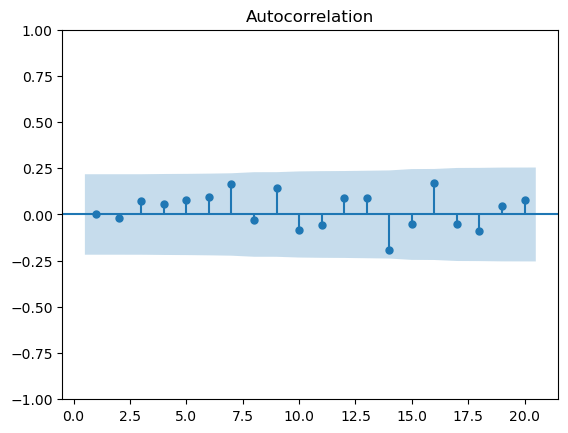

In [39]:
sgt.plot_acf(df_train.mod_ma6_resid[1:], zero=False);

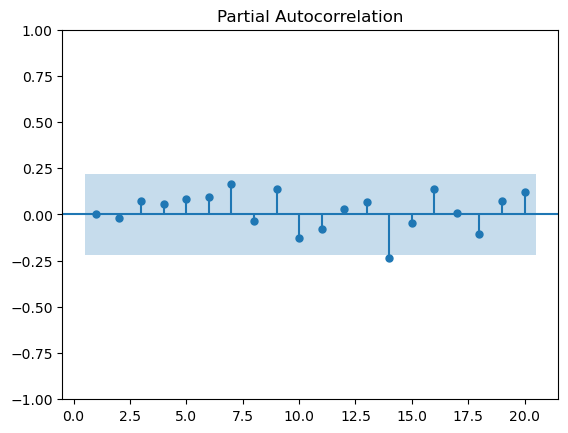

In [40]:
sgt.plot_pacf(df_train.mod_ma6_resid[1:], zero=False);

In [41]:
mod_ar1_ma1 = ARIMA(df_train.mkt_price, order=(1, 0, 1))
results_ar1_ma1 = mod_ar1_ma1.fit()
print(results_ar1_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  58.253
Date:                Sat, 07 Sep 2024   AIC                           -108.506
Time:                        15:45:01   BIC                            -98.879
Sample:                    04-05-2024   HQIC                          -104.641
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6377      0.166     27.980      0.000       4.313       4.963
ar.L1          0.9319      0.049     19.010      0.000       0.836       1.028
ma.L1          0.0306      0.128      0.240      0.8

In [42]:
mod_ar1_ma1 = ARIMA(df_train.returns, order=(1, 0, 1))
results_ar1_ma1 = mod_ar1_ma1.fit()
print(results_ar1_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -190.416
Date:                Sat, 07 Sep 2024   AIC                            388.832
Time:                        15:45:01   BIC                            398.459
Sample:                    04-05-2024   HQIC                           392.697
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2639      0.285     -0.927      0.354      -0.822       0.294
ar.L1         -0.0365      3.109     -0.012      0.991      -6.131       6.058
ma.L1          0.0017      3.114      0.001      1.0

In [43]:
sts.adfuller(df_train.mod_ma6_resid)

(-10.88070345538527,
 1.2970392612077143e-19,
 0,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 -96.36971937384001)

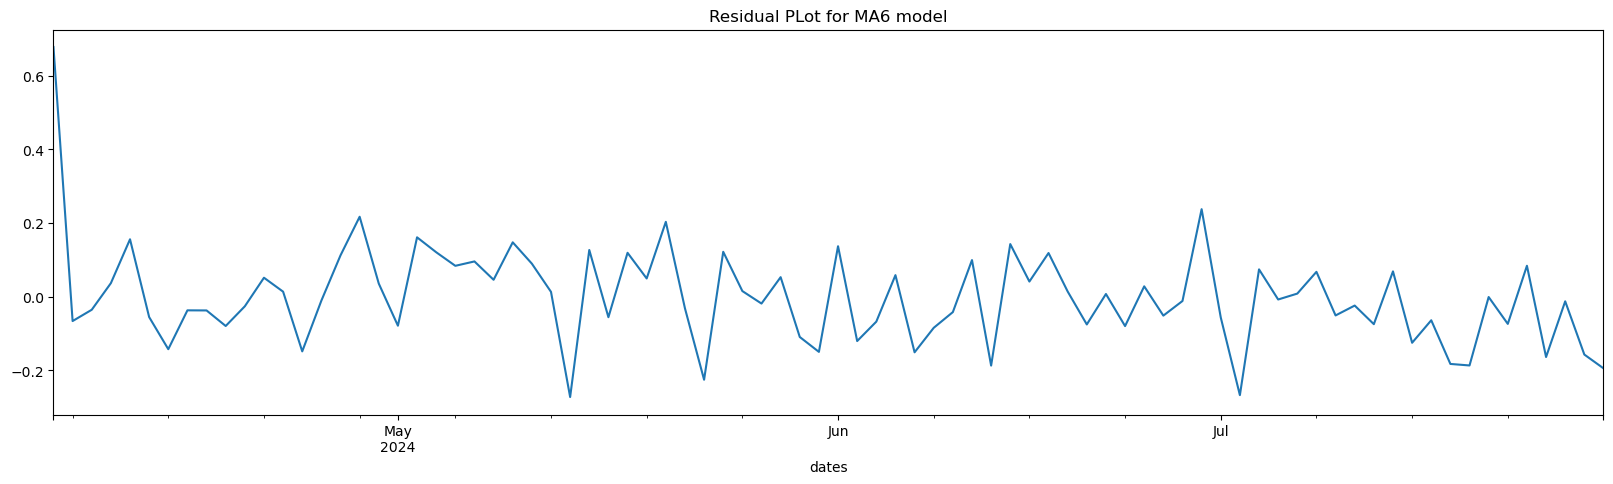

In [44]:
df_train.mod_ma6_resid.plot(figsize=(20, 5))
plt.title("Residual PLot for MA6 model");

In [45]:
df_train.mod_ma6_resid.mean(), df_train.mod_ma6_resid.var() 

(-0.0017453877763636259, 0.018216347326504664)